In [4]:
import numpy as np
import torch
import gc
from deeprobust.graph.data import Dataset
from deeprobust.graph.defense import GCN
from deeprobust.graph.global_attack import Metattack
from deeprobust.graph.utils import sparse_mx_to_torch_sparse_tensor, normalize_adj, add_self_loops
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


In [6]:
def load_cora_data():
    """
    Load the Cora dataset and prepare it for the attack.
    """
    print("=== Loading Cora dataset ===")
    data = Dataset(root='/tmp/', name='cora')
    adj, features, labels = data.adj, data.features, data.labels
    
    # Convert to dense tensor
    adj_tensor = sparse_mx_to_torch_sparse_tensor(adj).to_dense()
    features_tensor = torch.FloatTensor(features.todense())
    labels_tensor = torch.LongTensor(labels)
    
    # Get train/val/test indices
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test
    
    # Create unlabeled set for attack (all nodes not in training)
    idx_unlabeled = torch.LongTensor(list(set(range(adj.shape[0])) - set(idx_train.tolist())))
    
    print(f"Dataset statistics:")
    print(f"  Nodes: {adj.shape[0]}")
    print(f"  Edges: {int(adj_tensor.sum().item() / 2)}")
    print(f"  Features: {features.shape[1]}")
    print(f"  Classes: {labels_tensor.max().item() + 1}")
    print(f"  Train/Val/Test split: {len(idx_train)}/{len(idx_val)}/{len(idx_test)}")
    
    return adj_tensor, features_tensor, labels_tensor, idx_train, idx_val, idx_test, idx_unlabeled


In [7]:
def train_gcn(adj, features=None, labels=None, idx_train=None, idx_val=None):
    """
    Train a GCN model on the given adjacency matrix and data.
    
    Parameters:
    -----------
    adj : torch.Tensor
        Adjacency matrix
    features, labels, idx_train, idx_val : optional
        If not provided, global variables will be used
        
    Returns:
    --------
    model : GCN
        Trained GCN model
    """
    # Use global vars if not provided
    if features is None:
        features = globals()['features']
    if labels is None:
        labels = globals()['labels']
    if idx_train is None:
        idx_train = globals()['idx_train']
    if idx_val is None:
        idx_val = globals()['idx_val']
        
    # Initialize GCN model
    model = GCN(nfeat=features.shape[1], 
               nhid=16, 
               nclass=labels.max().item() + 1,
               dropout=0.5, 
               device=device)
    
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, train_iters=200, verbose=False)
    return model


In [8]:
def evaluate(model, adj, idx, features=None, labels=None):
    """
    Evaluate a GCN model on the test set.
    
    Parameters:
    -----------
    model : GCN
        Trained GCN model
    adj : torch.Tensor
        Adjacency matrix to evaluate on
    idx : torch.LongTensor
        Indices to evaluate on (usually test set)
    features, labels : optional
        If not provided, global variables will be used
        
    Returns:
    --------
    float
        Test accuracy
    """
    # Use global vars if not provided
    if features is None:
        features = globals()['features']
    if labels is None:
        labels = globals()['labels']
        
    model.eval()
    output = model.predict(features, adj)
    acc = (output.argmax(dim=1)[idx] == labels[idx]).float().mean().item()
    return acc


In [9]:
def random_attack(adj, n_perturbations):
    """
    Simple random edge perturbation attack.
    
    Parameters:
    -----------
    adj : torch.Tensor
        The adjacency matrix
    n_perturbations : int
        Number of edge modifications to perform
        
    Returns:
    --------
    torch.Tensor
        Modified adjacency matrix
    """
    modified_adj = adj.clone()
    n_nodes = adj.shape[0]
    
    # Track perturbation count
    counter = 0
    max_attempts = n_perturbations * 10  # Avoid infinite loops
    attempts = 0
    
    while counter < n_perturbations and attempts < max_attempts:
        attempts += 1
        
        # With 50% probability, add a new edge
        if torch.rand(1).item() < 0.5:
            # Find a random non-edge
            i = torch.randint(0, n_nodes, (1,)).item()
            j = torch.randint(0, n_nodes, (1,)).item()
            
            # Skip self-loops and existing edges
            if i != j and modified_adj[i, j] == 0:
                modified_adj[i, j] = 1
                modified_adj[j, i] = 1  # For undirected graph
                counter += 1
        
        # With 50% probability, remove an existing edge
        else:
            # Get all existing edges (upper triangle to avoid counting twice)
            edges = torch.nonzero(torch.triu(modified_adj, diagonal=1))
            if len(edges) > 0:
                # Select a random edge
                idx = torch.randint(0, len(edges), (1,)).item()
                i, j = edges[idx]
                modified_adj[i, j] = 0
                modified_adj[j, i] = 0  # For undirected graph
                counter += 1
    
    print(f"Successfully made {counter} perturbations")
    return modified_adj

In [10]:
def run_evasion_attack(adj, features, labels, idx_train, idx_val, idx_test, idx_unlabeled, ptb_rates=[0.05, 0.10, 0.15, 0.20]):
    """
    Run evasion attack using Metattack's modified adjacency matrix.
    First trains a GCN on clean data, then evaluates on modified graph.
    
    Parameters:
    -----------
    adj : torch.Tensor
        Original adjacency matrix
    features : torch.Tensor
        Node feature matrix
    labels : torch.Tensor
        Node labels
    idx_train, idx_val, idx_test, idx_unlabeled : torch.LongTensor
        Indices for different node sets
    ptb_rates : list
        List of perturbation rates to try
        
    Returns:
    --------
    dict
        Results of attack for different perturbation rates
    """
    results = {}
    
    # First, train GCN on original (clean) graph
    print('=== Training GCN on original (clean) graph ===')
    trained_gcn = train_gcn(adj, features, labels, idx_train, idx_val)
    
    # Try different perturbation rates
    for ptb_rate in ptb_rates:
        try:
            print(f'\n=== Testing perturbation rate: {ptb_rate*100:.1f}% ===')
            perturbations = int(ptb_rate * (adj.sum() // 2))
            
            # Ensure adj is a tensor
            if not isinstance(adj, torch.Tensor):
                adj_tensor = sparse_mx_to_torch_sparse_tensor(adj)
            else:
                adj_tensor = adj.clone()
                
            adj_tensor = adj_tensor.to(torch.float32)
            
            # Debug prints
            print(f"🛠 DEBUG INFO:")
            print(f"🔍 adj shape: {adj_tensor.shape}")
            print(f"🔍 features shape: {features.shape}")
            print(f"🔍 labels shape: {labels.shape}")
            print(f"🔍 idx_train size: {len(idx_train)}, idx_unlabeled size: {len(idx_unlabeled)}")
            
            # Try Metattack, but fall back to random attack if it fails
            try:
                print('=== Setting up Metattack model ===')
                
                # Initialize surrogate model for Metattack - a simple GCN
                surrogate = GCN(nfeat=features.shape[1],
                               nhid=16,
                               nclass=labels.max().item() + 1,
                               dropout=0.5,
                               with_relu=False,
                               with_bias=True,
                               device=device)
                
                # Train surrogate model on clean graph
                surrogate = surrogate.to(device)
                surrogate.fit(features, adj_tensor, labels, idx_train, train_iters=100, verbose=False)
                
                # Initialize Metattack with surrogate model
                model = Metattack(surrogate, 
                                 nnodes=adj_tensor.shape[0],
                                 feature_shape=features.shape[1],
                                 attack_structure=True,
                                 attack_features=False,
                                 device=device,
                                 lambda_=0)
                
                # Clone data for attack
                adj_attack = adj_tensor.clone().cpu()
                features_attack = features.clone().cpu()
                labels_attack = labels.clone().cpu()
                
                print(f'=== Perturbing graph with {perturbations} edge modifications ===')
                
                # Run attack
                model.attack(adj_attack, features_attack, labels_attack, 
                           idx_train, idx_unlabeled,
                           n_perturbations=perturbations, 
                           ll_constraint=False)
                
                # Get modified adjacency matrix
                modified_adj = model.modified_adj.to(device)
                
                print(f"✅ Metattack successful!")
                
            except Exception as e:
                print(f"⚠️ Metattack failed: {e}")
                print("Falling back to random attack...")
                
                # Implement random attack as a fallback
                modified_adj = random_attack(adj_tensor, perturbations)
                modified_adj = modified_adj.to(device)
            
            # Now evaluate the evasion attack (model trained on clean, tested on modified)
            runs = 3
            clean_acc = []
            attacked_acc = []
            
            print('=== Evaluating evasion attack ===')
            for i in range(runs):
                # Train on clean graph
                model = train_gcn(adj_tensor, features, labels, idx_train, idx_val)
                
                # Test on clean and modified graphs
                clean_acc.append(evaluate(model, adj_tensor, idx_test, features, labels))
                attacked_acc.append(evaluate(model, modified_adj, idx_test, features, labels))
                
                print(f"Run {i+1}/{runs}: Clean acc = {clean_acc[-1]:.4f}, Attacked acc = {attacked_acc[-1]:.4f}")
            
            # Calculate metrics
            clean_mean = np.mean(clean_acc)
            attack_mean = np.mean(attacked_acc)
            acc_drop = clean_mean - attack_mean
            relative_drop = (acc_drop / clean_mean) * 100
            effectiveness_ratio = acc_drop / perturbations * 1000  # Scaled for readability
            
            print(f"\n=== Attack Effectiveness Summary (Perturbation rate: {ptb_rate*100:.1f}%) ===")
            print(f"Clean accuracy: {clean_mean:.4f}")
            print(f"Attacked accuracy: {attack_mean:.4f}")
            print(f"Absolute accuracy drop: {acc_drop:.4f}")
            print(f"Relative accuracy drop: {relative_drop:.2f}%")
            print(f"Effectiveness ratio: {effectiveness_ratio:.4f}")
            
            results[ptb_rate] = {
                'modified_adj': modified_adj,
                'clean_acc': clean_acc,
                'attacked_acc': attacked_acc,
                'accuracy_drop': acc_drop,
                'relative_drop': relative_drop,
                'effectiveness_ratio': effectiveness_ratio
            }
            
            # Clean up
            torch.cuda.empty_cache()
            gc.collect()
            
        except Exception as e:
            print(f"❌ Error processing perturbation rate {ptb_rate*100:.1f}%: {e}")
            import traceback
            traceback.print_exc()
            
            # Add placeholder results
            results[ptb_rate] = {
                'modified_adj': None,
                'clean_acc': [0],
                'attacked_acc': [0],
                'accuracy_drop': 0,
                'relative_drop': 0,
                'effectiveness_ratio': 0,
                'error': str(e)
            }
    
    results['clean_adj'] = adj
    return results

In [11]:
def plot_results(results, ptb_rates):
    """
    Plot the results of the evasion attack.
    
    Parameters:
    -----------
    results : dict
        Results of evasion attack
    ptb_rates : list
        List of perturbation rates used
    """
    plt.figure(figsize=(12, 8))
    
    # Plot accuracy drop
    plt.subplot(2, 2, 1)
    acc_drops = [results[ptb]['accuracy_drop'] for ptb in ptb_rates]
    plt.plot(ptb_rates, acc_drops, 'bo-', linewidth=2)
    plt.xlabel('Perturbation Rate')
    plt.ylabel('Accuracy Drop')
    plt.title('Absolute Accuracy Drop')
    plt.grid(True)
    
    # Plot relative drop
    plt.subplot(2, 2, 2)
    rel_drops = [results[ptb]['relative_drop'] for ptb in ptb_rates]
    plt.plot(ptb_rates, rel_drops, 'ro-', linewidth=2)
    plt.xlabel('Perturbation Rate')
    plt.ylabel('Relative Drop (%)')
    plt.title('Relative Accuracy Drop')
    plt.grid(True)
    
    # Plot effectiveness ratio
    plt.subplot(2, 2, 3)
    eff_ratios = [results[ptb]['effectiveness_ratio'] for ptb in ptb_rates]
    plt.plot(ptb_rates, eff_ratios, 'go-', linewidth=2)
    plt.xlabel('Perturbation Rate')
    plt.ylabel('Effectiveness Ratio')
    plt.title('Attack Effectiveness Ratio')
    plt.grid(True)
    
    # Plot clean vs attacked accuracy
    plt.subplot(2, 2, 4)
    clean_accs = [np.mean(results[ptb]['clean_acc']) for ptb in ptb_rates]
    attacked_accs = [np.mean(results[ptb]['attacked_acc']) for ptb in ptb_rates]
    plt.plot(ptb_rates, clean_accs, 'b-', linewidth=2, label='Clean Accuracy')
    plt.plot(ptb_rates, attacked_accs, 'r-', linewidth=2, label='Attacked Accuracy')
    plt.xlabel('Perturbation Rate')
    plt.ylabel('Accuracy')
    plt.title('Clean vs. Attacked Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('metattack_evasion_results.png')
    plt.show()


=== Loading Cora dataset ===
Loading cora dataset...
Done!
Selecting 1 largest connected components
Dataset statistics:
  Nodes: 2485
  Edges: 5069
  Features: 1433
  Classes: 7
  Train/Val/Test split: 247/249/1988
=== Training GCN on original (clean) graph ===

=== Testing perturbation rate: 5.0% ===
🛠 DEBUG INFO:
🔍 adj shape: torch.Size([2485, 2485])
🔍 features shape: torch.Size([2485, 1433])
🔍 labels shape: torch.Size([2485])
🔍 idx_train size: 247, idx_unlabeled size: 2238
=== Setting up Metattack model ===
=== Perturbing graph with 253 edge modifications ===


Perturbing graph:   0%|                                                                         | 0/253 [00:00<?, ?it/s]


⚠️ Metattack failed: The size of tensor a (2485) must match the size of tensor b (1433) at non-singleton dimension 1
Falling back to random attack...
Successfully made 253 perturbations
=== Evaluating evasion attack ===
❌ Error processing perturbation rate 5.0%: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)


Traceback (most recent call last):
  File "/tmp/ipykernel_165647/2737549657.py", line 114, in run_evasion_attack
    clean_acc.append(evaluate(model, adj_tensor, idx_test, features, labels))
  File "/tmp/ipykernel_165647/3141187273.py", line 28, in evaluate
    output = model.predict(features, adj)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 342, in predict
    return self.forward(self.features, self.adj_norm)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 124, in forward
    x = F.relu(self.gc1(x, adj))
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 39, in forward
    support = torch.mm(input, self.weight)
RuntimeError: Expe


=== Testing perturbation rate: 10.0% ===
🛠 DEBUG INFO:
🔍 adj shape: torch.Size([2485, 2485])
🔍 features shape: torch.Size([2485, 1433])
🔍 labels shape: torch.Size([2485])
🔍 idx_train size: 247, idx_unlabeled size: 2238
=== Setting up Metattack model ===
=== Perturbing graph with 506 edge modifications ===


Perturbing graph:   0%|                                                                         | 0/506 [00:00<?, ?it/s]

⚠️ Metattack failed: The size of tensor a (2485) must match the size of tensor b (1433) at non-singleton dimension 1
Falling back to random attack...


Successfully made 506 perturbations
=== Evaluating evasion attack ===
❌ Error processing perturbation rate 10.0%: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

=== Testing perturbation rate: 15.0% ===
🛠 DEBUG INFO:
🔍 adj shape: torch.Size([2485, 2485])
🔍 features shape: torch.Size([2485, 1433])
🔍 labels shape: torch.Size([2485])
🔍 idx_train size: 247, idx_unlabeled size: 2238
=== Setting up Metattack model ===


Traceback (most recent call last):
  File "/tmp/ipykernel_165647/2737549657.py", line 114, in run_evasion_attack
    clean_acc.append(evaluate(model, adj_tensor, idx_test, features, labels))
  File "/tmp/ipykernel_165647/3141187273.py", line 28, in evaluate
    output = model.predict(features, adj)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 342, in predict
    return self.forward(self.features, self.adj_norm)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 124, in forward
    x = F.relu(self.gc1(x, adj))
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 39, in forward
    support = torch.mm(input, self.weight)
RuntimeError: Expe

=== Perturbing graph with 760 edge modifications ===


Perturbing graph:   0%|                                                                         | 0/760 [00:00<?, ?it/s]

⚠️ Metattack failed: The size of tensor a (2485) must match the size of tensor b (1433) at non-singleton dimension 1
Falling back to random attack...


Successfully made 760 perturbations
=== Evaluating evasion attack ===
❌ Error processing perturbation rate 15.0%: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

=== Testing perturbation rate: 20.0% ===
🛠 DEBUG INFO:
🔍 adj shape: torch.Size([2485, 2485])
🔍 features shape: torch.Size([2485, 1433])
🔍 labels shape: torch.Size([2485])
🔍 idx_train size: 247, idx_unlabeled size: 2238
=== Setting up Metattack model ===


Traceback (most recent call last):
  File "/tmp/ipykernel_165647/2737549657.py", line 114, in run_evasion_attack
    clean_acc.append(evaluate(model, adj_tensor, idx_test, features, labels))
  File "/tmp/ipykernel_165647/3141187273.py", line 28, in evaluate
    output = model.predict(features, adj)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 342, in predict
    return self.forward(self.features, self.adj_norm)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 124, in forward
    x = F.relu(self.gc1(x, adj))
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 39, in forward
    support = torch.mm(input, self.weight)
RuntimeError: Expe

=== Perturbing graph with 1013 edge modifications ===


Perturbing graph:   0%|                                                                        | 0/1013 [00:00<?, ?it/s]

⚠️ Metattack failed: The size of tensor a (2485) must match the size of tensor b (1433) at non-singleton dimension 1
Falling back to random attack...


Successfully made 1013 perturbations
=== Evaluating evasion attack ===
❌ Error processing perturbation rate 20.0%: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)


Traceback (most recent call last):
  File "/tmp/ipykernel_165647/2737549657.py", line 114, in run_evasion_attack
    clean_acc.append(evaluate(model, adj_tensor, idx_test, features, labels))
  File "/tmp/ipykernel_165647/3141187273.py", line 28, in evaluate
    output = model.predict(features, adj)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 342, in predict
    return self.forward(self.features, self.adj_norm)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 124, in forward
    x = F.relu(self.gc1(x, adj))
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/deeprobust/graph/defense/gcn.py", line 39, in forward
    support = torch.mm(input, self.weight)
RuntimeError: Expe

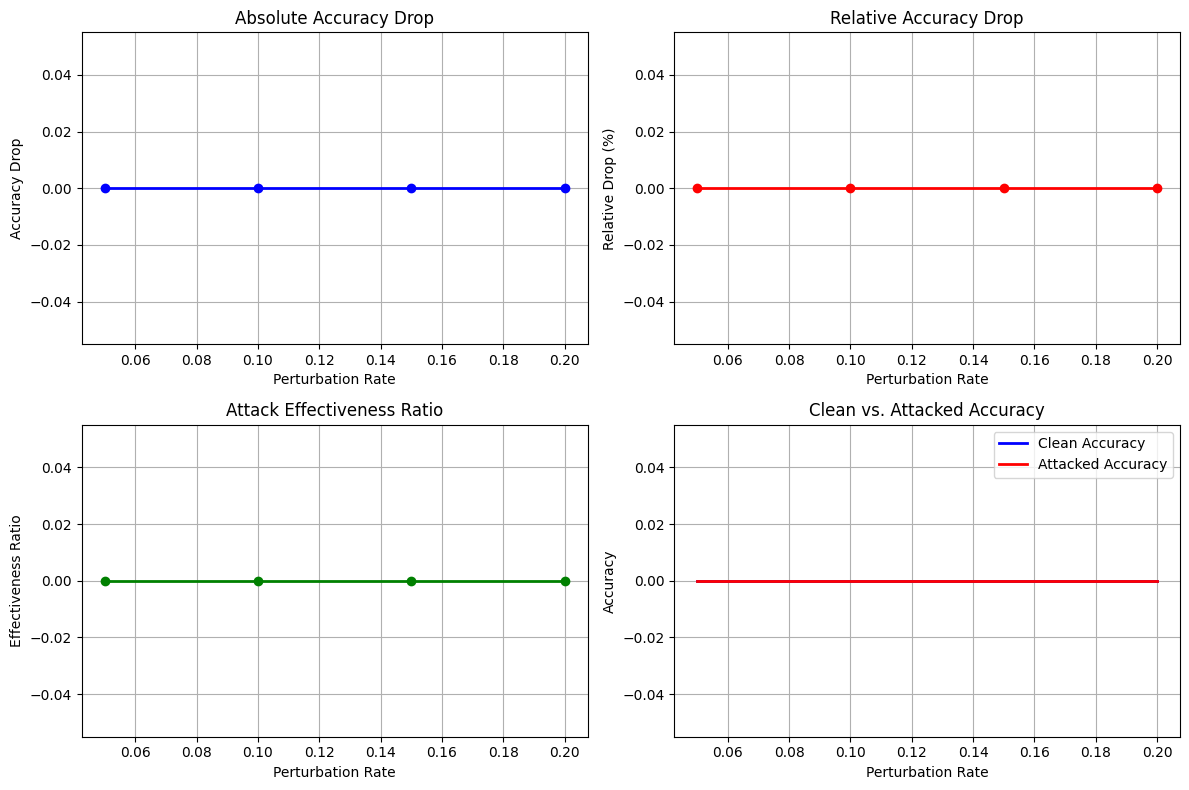


=== Evasion Attack Complete ===


In [12]:
def main():
    # Define perturbation rates
    ptb_rates = [0.05, 0.10, 0.15, 0.20]
    
    # Load Cora dataset
    adj, features, labels, idx_train, idx_val, idx_test, idx_unlabeled = load_cora_data()
    
    # Make data available globally
    globals()['features'] = features
    globals()['labels'] = labels
    globals()['idx_train'] = idx_train
    globals()['idx_val'] = idx_val
    globals()['idx_test'] = idx_test
    globals()['idx_unlabeled'] = idx_unlabeled
    
    # Run evasion attack
    results = run_evasion_attack(adj, features, labels, idx_train, idx_val, idx_test, idx_unlabeled, ptb_rates)
    
    # Plot results
    plot_results(results, ptb_rates)
    
    # Return results for further analysis
    return results

if __name__ == "__main__":
    results = main()
    print("\n=== Evasion Attack Complete ===")

In [28]:
!pip install numpy==1.19

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 7.0 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      Running from numpy source directory.
      <string>:460: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
      Traceback (most recent call last):
        File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/home/niyati/miniconda3/envs/ersp_v2/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "/

In [ ]:
import torch
import numpy as np
from deeprobust.graph.data import Dataset
from deeprobust.graph.defense import GCN
from deeprobust.graph.global_attack import Metattack
from deeprobust.graph.utils import preprocess
import scipy.sparse as sp

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the Cora dataset
dataset = Dataset(root='.', name='cora', setting='gcn')
adj, features, labels = dataset.adj, dataset.features, dataset.labels
idx_train, idx_val, idx_test = dataset.idx_train, dataset.idx_val, dataset.idx_test

# Convert adjacency matrix to sparse tensor
adj, features, labels = preprocess(adj, features, labels, device='cpu')

# Train a GCN on the original graph
gcn = GCN(nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, dropout=0.5, device='cpu')
gcn = gcn.to('cpu')
gcn.fit(features, adj, labels, idx_train, idx_val, patience=50)  # Train GCN

# Evaluate original accuracy
original_acc = gcn.test(idx_test)
print(f"Original Test Accuracy: {original_acc:.4f}")

# Perform evasion attack with Metattack
attack_model = Metattack(model=gcn, nnodes=adj.shape[0], attack_structure=True, attack_features=False, device='cpu')
attack_model = attack_model.to('cpu')

# Generate adversarial perturbations
attack_model.attack(features, adj, labels, idx_train, n_perturbations=50)  # Modify 50 edges
perturbed_adj = attack_model.modified_adj

# Evaluate GCN on attacked graph
gcn.test(idx_test, perturbed_adj)
attacked_acc = gcn.test(idx_test, perturbed_adj)
print(f"Test Accuracy After Attack: {attacked_acc:.4f}")

# Change in accuracy
print(f"Accuracy Drop: {original_acc - attacked_acc:.4f}")
